# Predicting Trial Outcomes, by Stupidmouse et. al.

- Mukund Mauji
- Zoë Scott
- Yuki Yanagita
- Sadiq Mobeen

<img src='./funky-mouse-photo.png'>


# The question (Zoe)

### Abstract

Even on a simple visual change detection task, on which perfect performance seems possible, mice routinely commit errors. Previous studies have shown that spike rates during stimulus onset in the primary visual cortex determine whether mice will detect a stimulus change (Cone at al. 2020). However, neural activity preceding the stimulus onset might modulate change detection as well. Furthermore, the mouse’s behavior preceding stimulus onset might influence its performance on the task. Therefore, it was examined whether neuronal activity and behavior before the onset of a stimulus can predict the trial outcome. We hypothesized that neural activation (from excitatory and inhibitory neurons in primary visual cortex), as well as behavioral variables (movement and pupil traces) preceding stimulus onset would allow us to predict post-hoc whether a mouse made an error in the task. Here, we fitted neural traces, behavior, and task variables such as reward history and stimulus novelty to a multinomial logistic regression model to classify trial outcomes into hits, correct rejections, misses, and false alarms. We found that classification performance was highest when using predictors a, b, c, while the predictors x,y,z turned out to have no predictive power. We conclude that trial outcomes, and specifically errors, are correlated with neural and behavioral processes preceding the onset of the visual target. Future research could examine the causal role of the identified predictors by selectively perturbing neural activity, for example using optogenetics or reversible brain stimulation. 

## The dataset and experimental setup

### Mouse task

<img src="https://allenswdb.github.io/_images/change_detection_task.png">

## Phenomena, Question, Goal

**Phenomena**

Why is the mouse making false alarms and misses?

**Question**

Which variables are correlated with the mouse making an error?

**Goal**

Our goal is to see if errors can be predicted solely by data collected from the mouse, before stimulus onset, using neural and behavioral data?

<img src="https://allenswdb.github.io/_images/Trial_diagram.png">

## Model setup

We used a multinomial logistic regression to model the relationship between 4 categorical dependent variables (the four possible trial outcomes) and one or more independent variables. 

The probability of observing each category of the dependent variable is modeled using the softmax function, which ensures that the predicted probabilities sum to one. The probability $P(y_i = k \mid \mathbf{x}_i)$ of the $i$-th observation belonging to category $k$ is given by:

$$ P(y_i = k \mid \mathbf{x}_i) = \frac{\exp(\mathbf{w}_k \cdot \mathbf{x}_i)}{\sum_{j=1}^{K} \exp(\mathbf{w}_j \cdot \mathbf{x}_i)} $$

where $\mathbf{w}_k$ represents the coefficients for category $k$, $\mathbf{x}_i$ is the feature vector for the $i$-th observation, and $K$ is the total number of categories. This approach allows us to predict the probabilities of each category based on the features of the input data.

## Trial details (Yuki)

<img src="https://allenswdb.github.io/_images/vbo_experimental_design_sessions.png">

# Preamble 

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import concurrent.futures
import sys, copy
from pprint import pprint
from sklearn.preprocessing import OneHotEncoder
import itertools
import copy

import sklearn
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from scipy.special import softmax

pd.set_option('display.max_columns', 500)

import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

import allensdk
print('allensdk version 2.10.2 or higher is required, you have {} installed'.format(allensdk.__version__))

allensdk version 2.10.2 or higher is required, you have 2.16.2 installed


In [5]:
%matplotlib inline

In [6]:
output_dir = Path("~/.cache/allensdk/visual_behavior_ophys_cache_dir").expanduser().resolve()
bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)
experiment_table = bc.get_ophys_experiment_table()    

/Users/mukund/dev/nma/venv/lib/python3.11/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


<div>
<img src="https://allensdk.readthedocs.io/en/latest/_static/visual_behavior_2p/data_structure.png", width="900"/>
</div>

In [7]:
## we have four datasets to choose from
experiment_table.project_code.unique()

vb_experiments = experiment_table.query('project_code == "VisualBehavior"')

## Why we chose VB experiments

We chose the simplest dataset to have some results in the short timeframe of NMA. However, there are more expansive datasets to be used

<img src="https://allenswdb.github.io/_images/vbo_dataset_variants.png">

# Choose a single mouse to work with

### Do all mice have the same number of experiments

Q) why do some mice have 11 experiment and others have 4??

A) some mice have repeated some days (eg OPHYS_1_A) and others have skipped other days (eg OPHYS_3_A)

Text(0.5, 1.0, 'Histogram of number of experiments per mouse (n=37)')

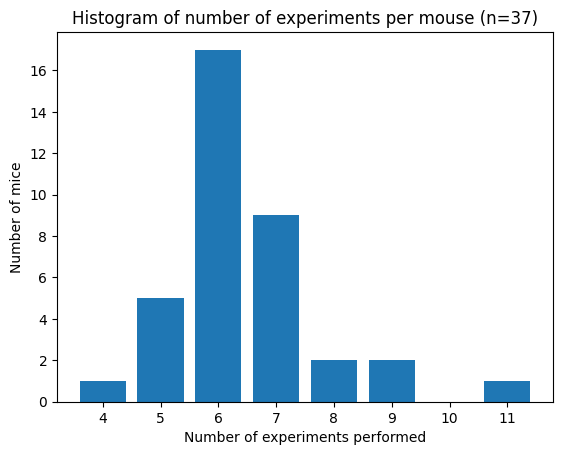

In [8]:
from pprint import pprint
from collections import Counter

sorted_mice_ids = sorted(vb_experiments.mouse_id.unique())
num_experiments_per_mouse = [len(vb_experiments.query('mouse_id == @mouse_id')) for mouse_id in sorted_mice_ids]

c = Counter(num_experiments_per_mouse)
xs = sorted(c.keys())

plt.bar(xs, [c[x] for x in xs])
plt.xlabel('Number of experiments performed')
plt.ylabel('Number of mice')
plt.title(f"Histogram of number of experiments per mouse (n={len(sorted_mice_ids)})")

### Let's only take mice with 6 experiments

In [90]:
cond = lambda id: len(vb_experiments.query('mouse_id == @id')) == 6
mice_with_6_experiments = list(filter(cond, sorted_mice_ids))

mouse1 = mice_with_6_experiments[0]
print(mouse1)

mouse2 = mice_with_6_experiments[1]

412036


# The pipeline (Mukund)

We will now make a pipeline to extract everything for a simple mouse

input: mouse_id

output: X,y to pass to scikit-learn and friends (X = design matrix, y = labels)

## helpers

In [19]:
# gets the tidy dff traces FOR A SINGLE EXPERIMENT
def make_tidy(exp):
    def get_cell_timeseries_dict(dataset, cell_specimen_id):
        '''
        for a given cell_specimen ID, this function creates a dictionary with the following keys
        * timestamps: ophys timestamps
        * cell_roi_id
        * cell_specimen_id
        * dff
        This is useful for generating a tidy dataframe
        arguments:
            session object
            cell_specimen_id
        returns
            dict
        '''
        cell_dict = {
            'timestamps': dataset.ophys_timestamps,
            'cell_roi_id': [dataset.dff_traces.loc[cell_specimen_id]['cell_roi_id']] * len(dataset.ophys_timestamps),
            'cell_specimen_id': [cell_specimen_id] * len(dataset.ophys_timestamps),
            'dff': dataset.dff_traces.loc[cell_specimen_id]['dff'],
    
        }
        return cell_dict
    
    tidy_dff_traces = pd.concat(
        [
            pd.DataFrame(get_cell_timeseries_dict(exp, cell_specimen_id)) 
            for cell_specimen_id in exp.dff_traces.reset_index()['cell_specimen_id']
        ]
    ).reset_index(drop=True)

    return tidy_dff_traces


# returns a dict containing all the experiment data for mouse_id
# we only keep data from active imaging days
def get_experiments(mouse_id: int) -> dict[str, _]:
    # returns a dict containing all the experiment data for mouse_id
    # we only keep data from active imaging days
    
    print(f"getting experiments for {mouse_id=} from vb_experiments")
    print(f"only keeping data from active imaging days")
    
    experiment_ids = vb_experiments.query('mouse_id == @mouse_id & behavior_type == "active_behavior"').index
    
    d = {exp_id: None for exp_id in experiment_ids}
    for exp_id in experiment_ids:
        exp = bc.get_behavior_ophys_experiment(exp_id)
        exp.tidy_dff = make_tidy(exp)
        d[exp_id] = exp

    return d


def make_colormap(exp):
    stimulus_presentations = exp.stimulus_presentations
    unique_stimuli = [stimulus for stimulus in stimulus_presentations['image_name'].unique() if stimulus != 'omitted']
    colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
    colormap['omitted'] = np.nan 
    return colormap


def stimuli_for_single_trial(exp, trial):
    simple_stim = exp.stimulus_presentations.query('image_index != -99') # remove the start and end movies
    return simple_stim.query('start_time >= {} and end_time <= {} '.format(float(trial.start_time), float(trial.stop_time)))


def dff_for_single_trial(exp, trial):
    return exp.tidy_dff.query('timestamps >= {} and timestamps <= {} '.format(float(trial.start_time), float(trial.change_time)))


def eye_tracking_data_for_single_trial(exp, trial):
    data = exp.eye_tracking.query('timestamps >= {} and timestamps <= {} '.format(float(trial.start_time), float(trial.change_time)))

    cols_with_raw_values = [x for x in exp.eye_tracking.columns if x.endswith('_raw')]
    
    cols_to_drop = ['timestamps', 'likely_blink']
    cols_to_drop.extend(cols_with_raw_values)

    filtered = data.drop(columns = ['timestamps', 'likely_blink'], axis=1)
    
    return filtered

## load some data

In [20]:
m1_data = get_experiments(mouse1)

getting experiments for mouse_id='412036' from vb_experiments
only keeping data from active imaging days


In [21]:
# used for quick prototyping
def play():
    exp = list(m1_data.values())[0]
    trials = exp.trials.query('aborted == False')
    return exp, trials

### what info do we have on each experiment

Which data would be good as predictors for trial outcome?

- neural activity
    - per cell type, per region, per imaging depth
- the decision strategy of the mouse
- physiological arousal (derived from movement and pupil data)
- familiarity and novelty of each stimulus
- expectation of upcoming change
- reward history
- neural noise

For simplicity, we only used neural activity in this notebook. Since we used the Visual Behavior dataset, we only have one cell type and one imaging depth.

In [16]:
m1_data[792815735].list_data_attributes_and_methods()

['average_projection',
 'behavior_session_id',
 'cell_specimen_table',
 'corrected_fluorescence_traces',
 'demixed_traces',
 'dff_traces',
 'events',
 'eye_tracking',
 'eye_tracking_rig_geometry',
 'get_cell_specimen_ids',
 'get_cell_specimen_indices',
 'get_dff_traces',
 'get_performance_metrics',
 'get_reward_rate',
 'get_rolling_performance_df',
 'get_segmentation_mask_image',
 'licks',
 'max_projection',
 'metadata',
 'motion_correction',
 'neuropil_traces',
 'ophys_experiment_id',
 'ophys_session_id',
 'ophys_timestamps',
 'raw_running_speed',
 'rewards',
 'roi_masks',
 'running_speed',
 'segmentation_mask_image',
 'stimulus_presentations',
 'stimulus_templates',
 'stimulus_timestamps',
 'task_parameters',
 'tidy_dff',
 'trials',
 'update_targeted_imaging_depth']

### mouse stats

Let's do a simple plot of the mouse's trial outcomes

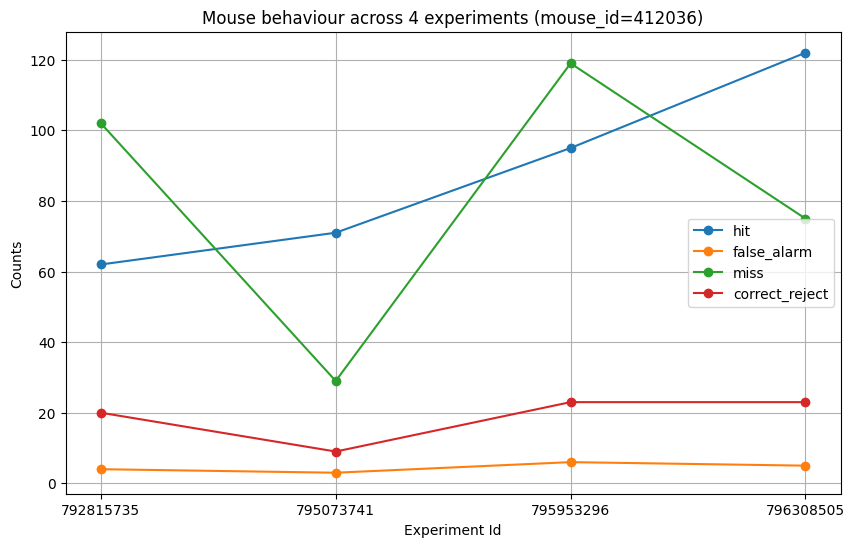

In [54]:
my_labels = ['hit', 'false_alarm', 'miss', 'correct_reject']

def mouse_stats(mouse_data, mouse_id):
    d = dict()
    for exp_index, (exp_id, exp) in enumerate(mouse_data.items()):
        trials = exp.trials.query('aborted == False')
        unique_cell_ids = exp.tidy_dff.cell_specimen_id.unique()

        z = dict()
        for label in my_labels:
            z[label] = len(trials.query(label))           
            
        d[exp_index] = (z, exp_id)

    return d


def plot_mouse_stats(stats):
    xs = list(stats.keys())
    
    plt.figure(figsize=(10, 6))
    
    for l in my_labels:
        y_values = [stats[key][0][l] for key in x_values]
        plt.plot(xs, y_values, label=l, marker='o', linestyle='-')
    
    plt.xlabel('Experiment Id')
    plt.ylabel('Counts')
    plt.title(f"Mouse behaviour across 4 experiments (mouse_id={mouse1})")
    
    xtick_labels = [stats[key][1] for key in x_values]
    plt.xticks(x_values, xtick_labels)
    
    plt.legend()
    plt.grid(True)
    plt.show()

m1_stats = mouse_stats(m1_data, mouse1)
plot_mouse_stats(m1_stats) 

## create design matrix and labels

In [50]:
exp, trials = play()

### make the design matrix

In [1578]:
def silly_feature_extractor(exp, trial):
    dff = dff_for_single_trial(exp, trial)
    
    ## this is very silly
    feature = dff.dff.mean()

    return np.array([feature])

my_labels = ['hit', 'false_alarm', 'miss', 'correct_reject']

def make_Xy(mouse_data, mouse_id):
    # the simplest one means only 1 feature per trial
    # and only 1 experiment

    all_cell_specimen_ids = np.concatenate(
        list(exp.tidy_dff.cell_specimen_id.unique() for exp in mouse_data.values())
    )
    unique_cell_specimen_ids = np.unique(all_cell_specimen_ids)
    num_unique_cell_specimen_ids = len(unique_cell_specimen_ids)

    num_extras = 1 + 21
    num_features = num_unique_cell_specimen_ids + num_extras
    
    y = np.empty((0, len(my_labels)))
    X = np.empty((0, num_features))

    y_cands = []
    X_cands = []
    
    for exp_index, (exp_id, exp) in enumerate(mouse_data.items()):            
        trials = exp.trials.query('aborted == False')
        trial_labels = trials[my_labels].astype(int).reset_index(drop=True).to_numpy()
        
        y_cands.append(trial_labels)

        shape = (len(trials), num_features)
        print(shape)
        X_exp = np.zeros(shape)
        
        for (trial_index, (_, trial)) in enumerate(trials.iterrows()):
            feature_vec = np.zeros((num_features))

            # feature vec is mean dff for each cell_specimen_id
            dff = dff_for_single_trial(exp, trial)
            dff = exp.tidy_dff.query('timestamps >= {} and timestamps <= {} '.format(float(trial.start_time), float(trial.change_time)))

            for cell_index, cell_id in enumerate(unique_cell_specimen_ids):
               feature_vec[cell_index] = dff.query('cell_specimen_id == @cell_id')['dff'].mean()

            offset = num_unique_cell_specimen_ids
            
            running_speed = exp.running_speed.query('timestamps >= {} and timestamps <= {} '.format(float(trial.start_time), float(trial.change_time)))
            feature_vec[offset] = running_speed.speed.mean()

            eye_tracking = eye_tracking_data_for_single_trial(exp, trial)
            feature_vec[offset + 1 : ] = eye_tracking.mean().to_numpy()

            X_exp[trial_index, :] = feature_vec
        
        X_cands.append(X_exp)

    y = np.vstack(y_cands)
    X = np.vstack(X_cands)

    return X,y

### make the design matrix (v2)

##### some notes

##### actually making the matrix

In [ ]:
my_labels = ['hit', 'false_alarm', 'miss', 'correct_reject']

def make_Xy(mouse_data, mouse_id, quick = False):
    y_cands = []
    X_cands = []
    all_categorical_data = []

    for exp_index, (exp_id, exp) in enumerate(mouse_data.items()):
        #if exp_index > 0:
            #continue

        print(f"starting trial {exp_index=} with {exp_id=}")
        
        trials = exp.trials.query('aborted == False')
        unique_cell_ids = exp.tidy_dff.cell_specimen_id.unique()

        if quick:
            trial_n = 10
            trial_iter = tqdm(enumerate(itertools.islice(trials.iterrows(), trial_n)), desc='trials', total=trial_n)
        else:
            trial_iter = tqdm(enumerate(trials.iterrows()), desc='trials', total=len(trials))

        for (trial_index, (trial_id, trial)) in trial_iter:
            label = trial[my_labels].astype(int).reset_index(drop=True).to_numpy()
            if label.ndim == 1:
                label = label.reshape(1, -1)

            t_start = float(trial.start_time)
            t_change = float(trial.change_time)
            trial_df = exp.tidy_dff.query(
                'timestamps >= @t_start and timestamps <= @t_change'
            )

            num_samples = 0

            for cell_specimen_id in unique_cell_ids:
                # dff traces for this trial and this specific cell id
                df = trial_df.query('cell_specimen_id == @cell_specimen_id')


                # relevant columns
                data = df[['dff', 'timestamps']].to_numpy()

            
                # normalize timestamps to trial start time
                data[:,1] -= t_start
                
                X_cands.append(data)
                num_samples += data.shape[0]

                categorical_data = np.array([exp_id, trial_id, cell_specimen_id]).reshape(1, -1)
                categorical_data = categorical_data.repeat(data.shape[0], axis=0)
                all_categorical_data.append(categorical_data)

            labels_for_trial = label.repeat(num_samples, axis=0)
            y_cands.append(labels_for_trial)
            
    y = np.vstack(y_cands)
    X = np.vstack(X_cands)
    all_categorical_data = np.vstack(all_categorical_data)

    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(all_categorical_data)
    encoded_data_array = encoded_data.toarray()

    print(X.shape, encoded_data_array.shape, len(all_categorical_data))
    
    X = np.hstack((X, encoded_data_array))

    if quick:
        print("WARNING: quick=True, only used limited subset of data")

    # we return the encoder so that we can reverse the encoding later for explanations
    return X,y, encoder

##### sanity check

In [52]:
%time X, y, encoder = make_Xy(m1_data, mouse1, quick=True)
assert X.shape[0] == y.shape[0]

starting trial exp_index=0 with exp_id=792815735


trials:   0%|          | 0/10 [00:00<?, ?it/s]

starting trial exp_index=1 with exp_id=795073741


trials:   0%|          | 0/10 [00:00<?, ?it/s]

starting trial exp_index=2 with exp_id=795953296


trials:   0%|          | 0/10 [00:00<?, ?it/s]

starting trial exp_index=3 with exp_id=796308505


trials:   0%|          | 0/10 [00:00<?, ?it/s]

(196620, 2) (196620, 95) 196620
CPU times: user 1.44 s, sys: 347 ms, total: 1.79 s
Wall time: 1.28 s


### populate X,y

In [53]:
%time X, y, encoder = make_Xy(m1_data, mouse1, quick=False)
X.shape, y.shape

starting trial exp_index=0 with exp_id=792815735


trials:   0%|          | 0/188 [00:00<?, ?it/s]

starting trial exp_index=1 with exp_id=795073741


trials:   0%|          | 0/112 [00:00<?, ?it/s]

starting trial exp_index=2 with exp_id=795953296


trials:   0%|          | 0/243 [00:00<?, ?it/s]

starting trial exp_index=3 with exp_id=796308505


trials:   0%|          | 0/225 [00:00<?, ?it/s]

(3737674, 2) (3737674, 644) 3737674
CPU times: user 26.5 s, sys: 12.5 s, total: 39 s
Wall time: 33 s


((3737674, 646), (3737674, 4))

##### what exactly is in our design matrix

In [68]:
def decode_row(row: np.array, encoder: sklearn.preprocessing.OneHotEncoder):
    assert row.ndim == 1

    dff_value = row[0]
    offset = row[1]
    
    decoded = encoder.inverse_transform(row[2:].reshape(1,-1))
    
    experiment_id = decoded[0][0]
    trial_id = decoded[0][1]
    cell_specimen_id = decoded[0][2]

    print(f"this row represents {dff_value=} taken {offset} seconds after trial start")
    print(f"this data comes from {experiment_id=}, {trial_id=}, {cell_specimen_id=}")

In [91]:
print("decoding first row")
decode_row(X[1], encoder)

decoding first row
this row represents dff_value=-0.008969936519861221 taken 0.04931999999996606 seconds after trial start
this data comes from experiment_id=792815735, trial_id=0, cell_specimen_id=1086490397


In [92]:
print("decoding last row")
decode_row(X[-1], encoder)

decoding last row
this row represents dff_value=0.027754489332437515 taken 3.7678399999999783 seconds after trial start
this data comes from experiment_id=796308505, trial_id=738, cell_specimen_id=1086490790


## lets fit some models!!

#### good candidates for slides

In [1804]:
from sklearn.preprocessing import OneHotEncoder

# Example categorical data
categorical_data = [['cat', 'small'],
                    ['dog', 'medium'],
                    ['dog', 'large'],
                    ['cat', 'small']]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the categorical data and transform it
encoded_data = encoder.fit_transform(categorical_data)

# Convert the sparse matrix to a dense array for visualization
encoded_data_array = encoded_data.toarray()


print("Encoded data:")
print(encoded_data_array)

temps = np.random.rand(4, 1) * 10
temps

print(np.hstack((temps, encoded_data_array)))

Encoded data:
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1.]]
[[1.60787157 1.         0.         0.         0.         1.        ]
 [1.84834802 0.         1.         0.         1.         0.        ]
 [1.36171385 0.         1.         1.         0.         0.        ]
 [5.06478685 1.         0.         0.         0.         1.        ]]


#### imputation adventures

In [2172]:
def impute_by_mean(target_X):
    new_X = copy.deepcopy(target_X)
    for i in range(768):
        myrow = new_X[i]
        all_numeric_in_row = myrow[~np.isnan(myrow)].sum()
        replacement = all_numeric_in_row.mean()
        myrow[np.isnan(myrow)] = replacement

    return new_X

X3 = impute_by_mean(X)

### fit a classifier

#### test/train split

In [55]:
clf = linear_model.LogisticRegression(
    penalty = 'l1',
    multi_class = 'multinomial',
    solver="saga",
    tol = 0.1,
)

y2 = np.argmax(y, axis = 1)
%time X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=12)

CPU times: user 2.3 s, sys: 10.2 s, total: 12.5 s
Wall time: 15.7 s


#### fit and predict

In [60]:
%time clf = clf.fit(X_train, y_train)
%time y_pred = clf.predict(X_test)

CPU times: user 1min 6s, sys: 11.4 s, total: 1min 18s
Wall time: 1min 21s
CPU times: user 4.24 s, sys: 801 ms, total: 5.04 s
Wall time: 1.93 s


#### basic scoring

In [62]:
l1_accuracy = accuracy_score(y_test, y_pred)
l1_sparsity = np.mean(clf.coef_ == 0) * 100
l1_score = clf.score(X_test, y_test)

print("Accuracy with L1 penalty: %.4f" % l1_accuracy)
print("Sparsity with L1 penalty: %.2f%%" % l1_sparsity)
print("Test score with L1 penalty: %.4f" % l1_score)

Accuracy with L1 penalty: 0.9502
Sparsity with L1 penalty: 0.00%
Test score with L1 penalty: 0.9502


#### confusion matrices

##### Normalized across all values

this means that `np.sum(cm) == 1`

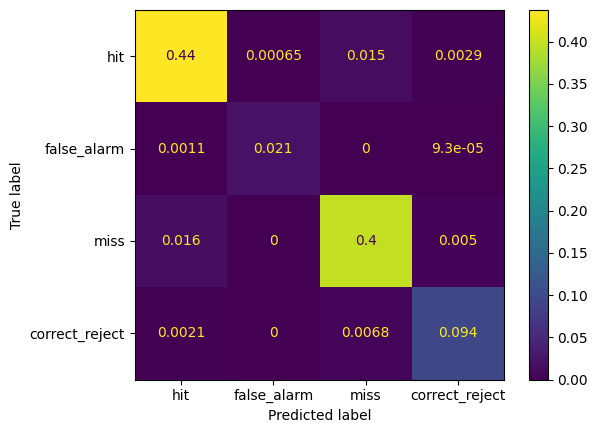

In [63]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=my_labels, normalize='all', include_values=True)

##### Normalized across 'true' values

this means that `np.sum(row) == 1 for row in cm`

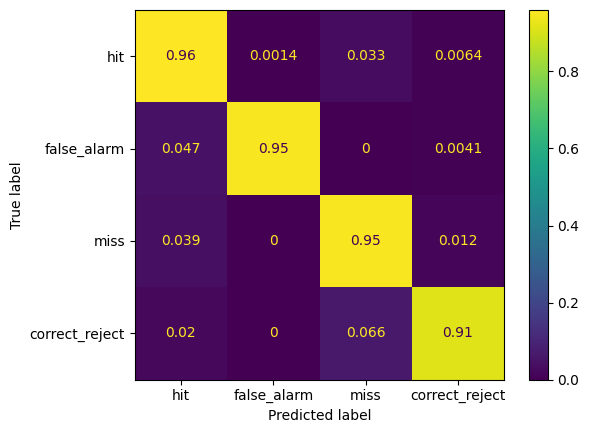

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=my_labels, normalize='true', include_values=True)

# Conclusion (Sadiq)

The good fit of the Logistic Regression shows that high accuracy is principally achievable with a linear model. 

The inclusion of trial-to-trial variation and cell-to-cell variation as dummy variables (via one-hot encoding) significantly improved out prediction accuracy. 

We would like to leverage the high interpretability of a linear model by adding in other features in future work to determine how they help predict trial outcome.

These other features can be both measured (eg. running speed) or derived (eg. physiological arousal via pupil data). Further, we can leverage the other experimental setups (eg. VisualBehaviorMultiscope) to see the influence of imaging depth on prediction accuracy. 

Our work was only using data from a single mouse. Including data from all mice will allow us to draw conclusions abot the role of excitatory vs inhibitory cells, as well as different cortical regions.